# TFM



In [97]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


- libraries

In [100]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [101]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Conv2D, Dense, Dropout, MaxPooling2D, Flatten
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import Adam #, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# my functions # i'll write here at the end the functions i'm using below
# from my_functions import freezing_layers, vgg16_19_conf, resnet50_conf, nn_parameters, plotting_model, generic_last_2layers

In [102]:
# to be able to use my functions in the notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

- paths

In [99]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/" #for pickling data
input = input_folder+"House_Room_Dataset-5_rooms" # for requesting directly pics
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [98]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides   input    src
'Dudas y seguimiento TFM.gdoc'					  output


- functions

In [109]:
def vgg19(data_augmentation, base_model, dropout_layers: bool, dropout_position: str, dropout_percent: float, num_classes):
  '''
  using all vgg19 trained layers but top-model, which is included for transfer-learning. last layer equals to the num_classes
  EX: vgg19(data_augmentation=None, base_model= base_model, dropout_layers=False, dropout_position= None, dropout_percent=None, num_classes=5)
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(base_model)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
    
  pre_trained.add(layers.Dense(num_classes,activation=('softmax')))

  return pre_trained


def plotting_model(model, epochs, name, location):
  #Plotting the training and validation loss and accuracy
  
  f,ax=plt.subplots(2, 1, figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), model.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), model.history["val_loss"], label="val_loss")
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), model.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), model.history["val_accuracy"], label="val_acc")
  ax[1].legend()
  #plt.legend()
  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  #plt.title("Training Loss and Accuracy", loc="left")
  plt.savefig(location)
  plt.show()

def model_evaluation(evaluation, output_folder:str, name:str):
  # evaluation the model with val_ds
  models_metrics = {}  
  models_metrics[m] = evaluation
  # saving the metris in json file
  with open(output_folder+name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)
  return models_metrics

def classification_report_pic(y_pred, validation_ds, class_names, output_folder, name):
  numeric_values_val = list(validation_ds.map(lambda x, y: y))
  y_target = []
  for arr in numeric_values_val:
    y_target.append(arr)
  y_target = list(chain.from_iterable(y_target))
  # transform to np array
  y_target = np.array(y_target)
  #print(y_target.shape)

  print(classification_report(y_pred , y_target, target_names=class_names))
  clf_report = classification_report(y_pred , y_target, target_names=class_names, output_dict=True )
  # .iloc[:-1, :] to exclude support
  plt.figure(figsize = (10,8))
  plt.title("classification report: "+name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  plt.savefig(output_folder+name+"-classification_report.png")
  plt.show()

def confusion_matrix_report(val_ds, y_pred, class_names, output_folder, name):
    #cm = confusion_matrix(y_pred, y_target)
    true_categories = tf.concat([y for x, y in val_ds], axis=0)
    cm = confusion_matrix(true_categories, y_pred, normalize="true" ) #,  labels=[class_names])
    df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
    fig = plt.figure(figsize = (10,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.title("confusion matrix: "+name)
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.savefig(output_folder+name+"-confusion_matrix.png")
    plt.show()

# getting pics from folder instead of pickling them

In previous versions I used a pickled dataset to work with. That was quite a mess, because it loads the full dataset in memory, so sometimes the notebook crashed. Now I batch process the pictures with this keras method => https://keras.io/examples/vision/image_classification_from_scratch/
- *image_dataset_from_directory* has no train-test-val. it has just train-val.

In [103]:
image_size = (128,128)
batch_size = 128 # 32

In [104]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
train_ds = image_dataset_from_directory(
    input,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    # labels='inferred',
    # label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb'
)

Found 5250 files belonging to 5 classes.
Using 4200 files for training.


In [105]:
# validation set (use the same seed and split)
val_ds = image_dataset_from_directory( # utilizar el de validación como test
    input,
    # labels='inferred',
    # label_mode='categorical',
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb'
)

Found 5250 files belonging to 5 classes.
Using 1050 files for validation.


In [106]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

# data augmentation

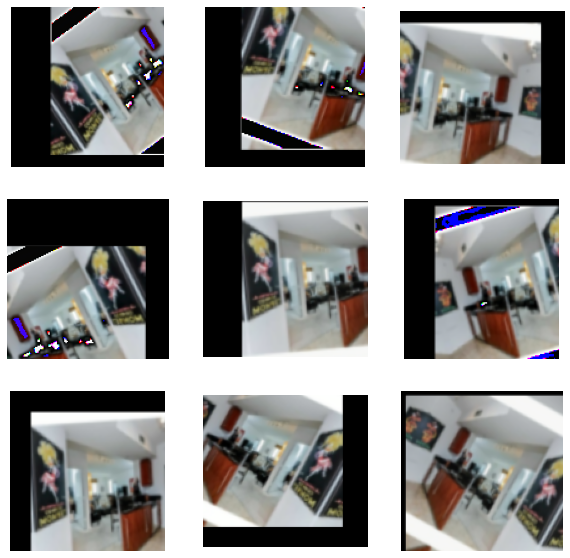

In [107]:
# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [
    layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.005),
    #random_invert(0.2),  # color inversion
    layers.RandomContrast(0.1),
    #Contrast(),
    #layers.RandomCrop(image_size[0],image_size[1]), 
    layers.RandomWidth(0.05, interpolation="gaussian"),
    layers.RandomHeight(0.05),
    layers.RandomTranslation((-0.2,0.3),(-0.2,0.3), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# vgg19 with/without data augmentation

In [108]:
# VGG19. all this models and configurations are going to be tested
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
vgg19_dict = {
    #"AATEST"       : vgg19(data_augmentation=None,               base_model= base_model, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),
    "vgg19_NOdataAug_NOdropout"       : vgg19(data_augmentation=None,               base_model= base_model, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),
    "vgg19_dataAug_dropoutFirst0.2"   : vgg19(data_augmentation=data_augmentation,  base_model= base_model, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    "vgg19_NOdataAug_dropoutFirst0.2" : vgg19(data_augmentation=None,               base_model= base_model, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    "vgg19_dataAug_dropoutMiddle0.2"  : vgg19(data_augmentation=data_augmentation,  base_model= base_model, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    "vgg19_NOdataAug_dropoutMiddle0.2": vgg19(data_augmentation=None,               base_model= base_model, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    "vgg19_dataAug_NOdropout"         : vgg19(data_augmentation=data_augmentation,  base_model= base_model, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5)              
}


 AATEST
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_14  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 20,026,949
Trainable params: 2,565
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 14s 353ms/step - loss: 5.8686 - accuracy: 0.2764 - val_loss: 4.2258 - val_accuracy: 0.3419
Epoch 2/2
33/33 [==============================] - 13s 340ms/step - loss: 3.4361 - accuracy: 0.4217 - val_loss: 3.0888 - val_accuracy: 0.4429
run epochs:  2


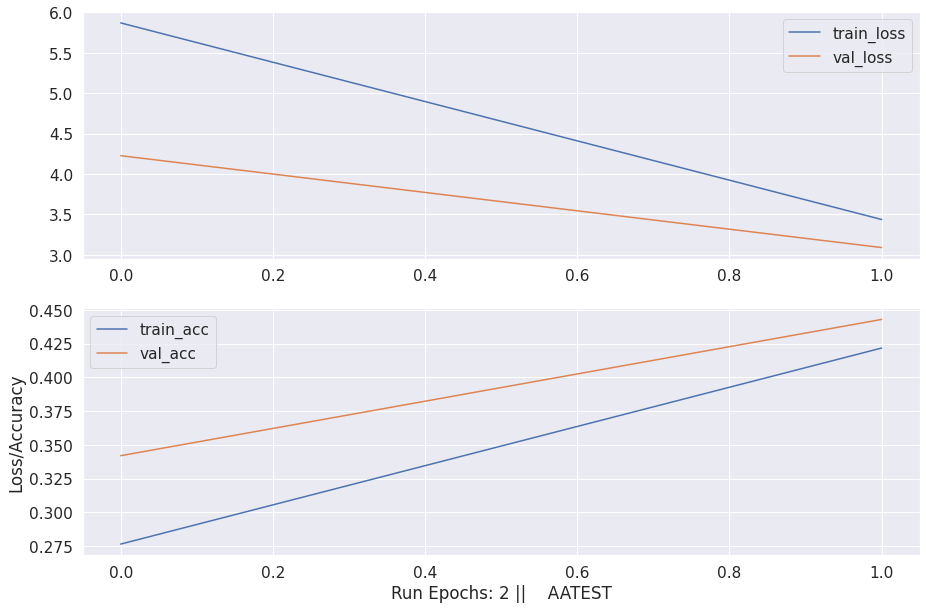

9/9 [==============================] - 3s 169ms/step - loss: 3.0888 - accuracy: 0.4429
              precision    recall  f1-score   support

     Bedroom       0.17      0.20      0.18       203
    Bathroom       0.22      0.14      0.17       152
     Dinning       0.21      0.23      0.22       219
  Livingroom       0.28      0.26      0.27       275
     Kitchen       0.21      0.21      0.21       201

    accuracy                           0.22      1050
   macro avg       0.22      0.21      0.21      1050
weighted avg       0.22      0.22      0.22      1050



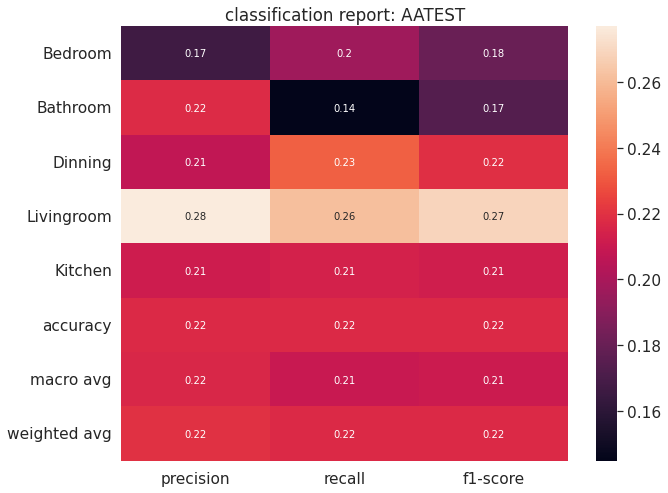

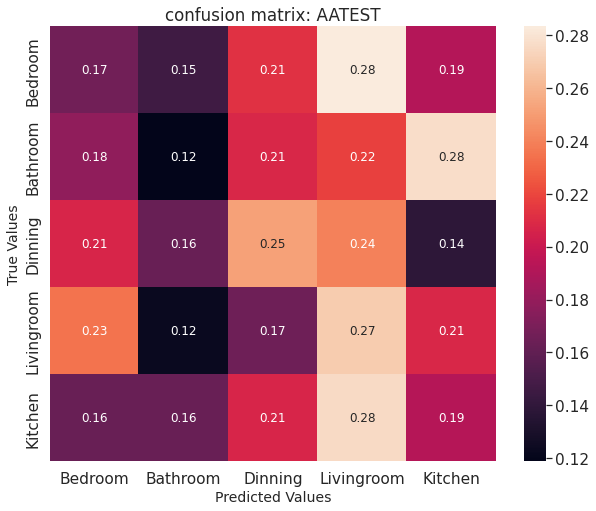

In [110]:
callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor="val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )
]

epochs = 2
for m in vgg19_dict:
  print("\n", m)
  vgg19_dict[m].summary()

  vgg19_dict[m].compile( optimizer = "adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', , 
                metrics=['accuracy'] # "recall"
                )

  history = vgg19_dict[m].fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        #callbacks = callbacks
        )
  
  number_of_epochs_it_ran = len(history.history['loss']) 
  print("run epochs: ",number_of_epochs_it_ran)
  name = m
  vgg19_dict[m].save(output_folder+name+".h5")

  # saving model accuracy/loss graph
  plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 
  
  # saving model metrics to json
  evaluation = vgg19_dict[m].evaluate(val_ds, batch_size=batch_size, return_dict=True)
  model_evaluation(evaluation, output_folder, name)

  # get inferences
  y_pred_float = vgg19_dict[m].predict(val_ds)
  y_pred = np.argmax(y_pred_float, axis=1) 

  # classification and confusion matrix reports
  classification_report_pic(y_pred, val_ds, class_names, output_folder, name)
  confusion_matrix_report(val_ds, y_pred, class_names, output_folder, name)

# compiling and running code manually

manual example of what we're doing above

In [111]:
asdfasdfasdfasf

NameError: ignored

In [ ]:
# this is a nn from a dictionary written above. create the nn ready for transfer-learning
vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].compile( optimizer = "adam", 
                 loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', , 
                metrics=['accuracy'] 
                )

# callbacks just for first approach
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1,
#     )
# ]

epochs = 200
# fit the model
history = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      #callbacks = callbacks
      )

In [ ]:
def plotting_model(model, epochs, name, location):
  #Plotting the training and validation loss and accuracy
  
  f,ax=plt.subplots(2,1,figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), model.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), model.history["val_loss"], label="val_loss")
  ax[0].grid(True)
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), model.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), model.history["val_accuracy"], label="val_acc")
  ax[1].legend()
  #plt.legend()
  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  ax[1].grid(True)
  #ax[0].title("Training Loss and Accuracy", loc="left")
  plt.savefig(location)
  plt.show()

### saving the model. loss/accuracy

In [ ]:
# loss/accuracy and saving the model
number_of_epochs_it_ran = len(history.history['loss']) 
print(number_of_epochs_it_ran)
name = "vgg19_dataAug_dropoutFirst0.2"
vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].save(output_folder+name+".h5")

plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 

### model performance

In [ ]:
# evaluation the model with val_ds
models_metrics = {}
evaluation = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].evaluate(val_ds, batch_size=batch_size, return_dict=True)
models_metrics["vgg19_dataAug_dropoutFirst0.2"] = evaluation
models_metrics

In [ ]:
import json
# saving the metrics in a json
with open(name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)

### saving the classifitacion report to a file

we need a flat array of real labels, and a flat one of infererd labels in order to create our sk-learn classification report, and it's tricky somehow.
- the inferred labels come as a float array (with percentage of belonging to a class), we have to transform it into an int array, where the highest probabilities are turned into a 1 and rest into 0.
- the real labels are inserted into the val_ds tensorflow stuff, and we have to extract the info saved in batches out of there), and create the array.

In [ ]:
# create inferences
y_pred_float = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].predict(val_ds)
print(y_pred_float.shape)
# now let's turn it into a 1050x1 array, where it's value will be the associated class
y_pred = np.argmax(y_pred_float, axis=1) 
print(y_pred.shape)

# extract the real labels
numeric_values_val = list(val_ds.map(lambda x, y: y))
y_target = []


# real lables are kind of a list of  lists, with as much lists as batches we had
for arr in numeric_values_val:
  y_target.append(arr)
# flatten it to a list
y_target = list(chain.from_iterable(y_target))
# transform to a np array
y_target = np.array(y_target)
y_target.shape

# classification report
print(classification_report(y_pred , y_target, target_names=class_names))
# create a image from that output
clf_report = classification_report(y_pred , y_target, target_names=class_names,output_dict=True )
plt.figure(figsize = (10,8))
plt.title("vgg19_dataAug_dropoutFirst0.2")
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.savefig(output_folder+name+"-classification_report.png")
plt.show()

### confusion matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_precision_recall_curve
cm = confusion_matrix(y_pred, y_target)

In [ ]:
class_names

In [ ]:
true_categories = tf.concat([y for x, y in val_ds], axis=0)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_categories, y_pred, normalize="true" ) #,  labels=[class_names])
df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.title("confusion matrix: "+name)
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.savefig(output_folder+name+"-confusion_matrix.png")
plt.show()